1. Выбор и загрузка датасета с Kaggle, будем использовать набор данных "Cardekho Used Car Data", который содержит информацию о продажах подержанных автомобилей в Индии.

In [6]:
# Импортируем необходимые библиотеки
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# URL датасета (Kaggle: Cardekho Used Car Data)
url = 'https://raw.githubusercontent.com/YBI-Foundation/Dataset/main/Car%20Price.csv'

# Загружаем данные в DataFrame
df = pd.read_csv(url)

# Посмотрим на первые 5 строк, чтобы понять структуру данных
print("Структура датасета 'Used Car Data':")
print(df.head())

Структура датасета 'Used Car Data':
     Brand                     Model  Year  Selling_Price  KM_Driven    Fuel  \
0   Maruti             Maruti 800 AC  2007          60000      70000  Petrol   
1   Maruti  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2  Hyundai      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3   Datsun    Datsun RediGO T Option  2017         250000      46000  Petrol   
4    Honda     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  Seller_Type Transmission         Owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  


2. Создание новой базы данных SQLite
Cоздадим новую, "автомобильную" базу данных с именем cars.db.

In [7]:
# Создаем и подключаемся к базе данных SQLite
conn = sqlite3.connect('cars.db')

3. Создание таблицы и импорт данных
Создаем таблицу car_listings и определим типы данных для каждого столбца.

In [14]:
# Создаем курсор для выполнения SQL-команд
cursor = conn.cursor()

# SQL-запрос для создания таблицы
cursor.execute('''
CREATE TABLE IF NOT EXISTS car_listings (
    Car_Name TEXT,
    Year INTEGER,
    Selling_Price REAL,
    Present_Price REAL,
    KM_Driven INTEGER,
    Fuel TEXT,
    Seller_Type TEXT,
    Transmission TEXT,
    Owner INTEGER
);
''')

# Импортируем данные из DataFrame в созданную таблицу
df.to_sql('car_listings', conn, if_exists='replace', index=False)

print("\nБаза данных 'cars.db' и таблица 'car_listings' успешно созданы, данные импортированы.")


База данных 'cars.db' и таблица 'car_listings' успешно созданы, данные импортированы.


4. SQL-запросы с фильтрацией (WHERE)
Извлечем конкретные данные.

Запрос 1: Найти все дизельные автомобили (Fuel_Type = 'Diesel') с автоматической коробкой передач (Transmission = 'Automatic').

In [15]:
query1 = """
SELECT Model, Year, Selling_Price, KM_Driven
FROM car_listings
WHERE Fuel = 'Diesel' AND Transmission = 'Automatic';
"""
df_filtered_1 = pd.read_sql_query(query1, conn)
print("\nДизельные автомобили с автоматической коробкой передач:")
print(df_filtered_1.head())


Дизельные автомобили с автоматической коробкой передач:
                                  Model  Year  Selling_Price  KM_Driven
0            Jaguar XF 2.2 Litre Luxury  2014        1964999      28000
1  Mercedes-Benz New C-Class 220 CDI AT  2013        1425000      59000
2     Maruti Vitara Brezza ZDi Plus AMT  2018         975000       4500
3                       Audi Q5 2.0 TDI  2011        1190000     175900
4       Audi A6 2.0 TDI  Design Edition  2013        1735000      50000


Запрос 2: Найти автомобили, выпущенные после 2016 года, с пробегом менее 20 000 км.

In [13]:
query2 = """
SELECT Model, Year, Selling_Price, KM_Driven
FROM car_listings
WHERE Year > 2016 AND KM_Driven < 20000;
"""
df_filtered_2 = pd.read_sql_query(query2, conn)
print("\nАвтомобили новее 2016 года с пробегом до 20 000 км:")
print(df_filtered_2.head())


Автомобили новее 2016 года с пробегом до 20 000 км:
                               Model  Year  Selling_Price  KM_Driven
0        Hyundai Venue SX Opt Diesel  2019        1195000       5000
1  Maruti Vitara Brezza ZDi Plus AMT  2018         975000       4500
2                    Honda City V MT  2018         930000      14500
3         Tata Tigor 1.2 Revotron XT  2018         525000      15000
4   Jeep Compass 1.4 Sport Plus BSIV  2019        1400000      10000


5. SQL-запросы с агрегатными функциями
Посчитаем некоторые общие статистики по нашему автопарку.

Запрос 3: Посчитать среднюю цену продажи (AVG), максимальный пробег (MAX) и общее количество (COUNT) автомобилей для каждого типа топлива (Fuel_Type).

In [16]:
query3 = """
SELECT
    Fuel,
    COUNT(*) AS number_of_cars,
    AVG(Selling_Price) AS average_price,
    MAX(KM_Driven) AS max_kms_driven
FROM
    car_listings
GROUP BY
    Fuel;
"""
df_agg = pd.read_sql_query(query3, conn)
print("\nАгрегированная статистика по типам топлива:")
print(df_agg)


Агрегированная статистика по типам топлива:
       Fuel  number_of_cars  average_price  max_kms_driven
0       CNG              40  277174.925000          120000
1    Diesel            2153  669094.252206          560000
2  Electric               1  310000.000000           62000
3       LPG              23  167826.043478          170000
4    Petrol            2123  344840.137541          806599


6. Визуализация данных - представим полученные данные в виде наглядных графиков.

График 1: Распределение автомобилей по году выпуска

Этот график покажет, автомобили каких годов преобладают в наборе данных.

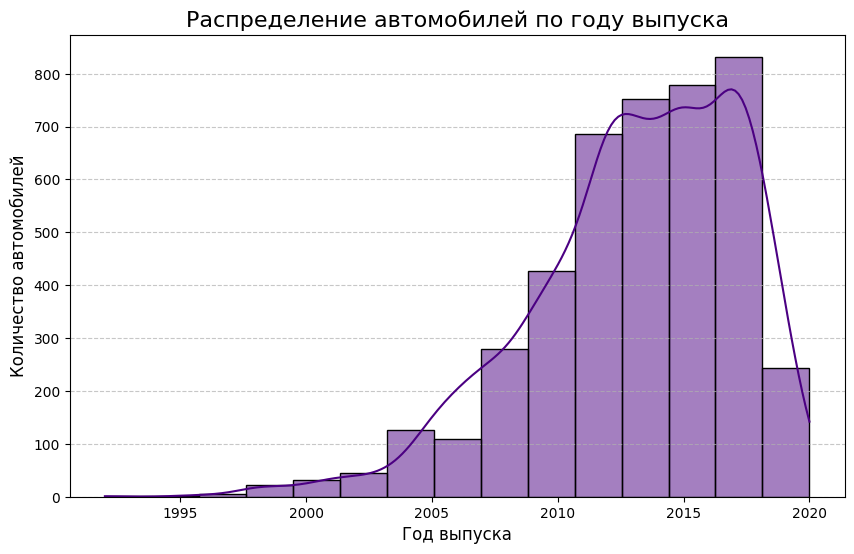

In [17]:
# Получаем данные о годах выпуска
year_data_query = "SELECT Year FROM car_listings;"
df_year = pd.read_sql_query(year_data_query, conn)

# Строим гистограмму
plt.figure(figsize=(10, 6))
sns.histplot(df_year['Year'], bins=15, kde=True, color='indigo')
plt.title('Распределение автомобилей по году выпуска', fontsize=16)
plt.xlabel('Год выпуска', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

График 2: Средняя цена продажи в зависимости от типа топлива

Используем данные из нашего агрегатного запроса (df_agg), чтобы сравнить цены.

/tmp/ipython-input-2048134601.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fuel', y='average_price', data=df_agg, palette='plasma')


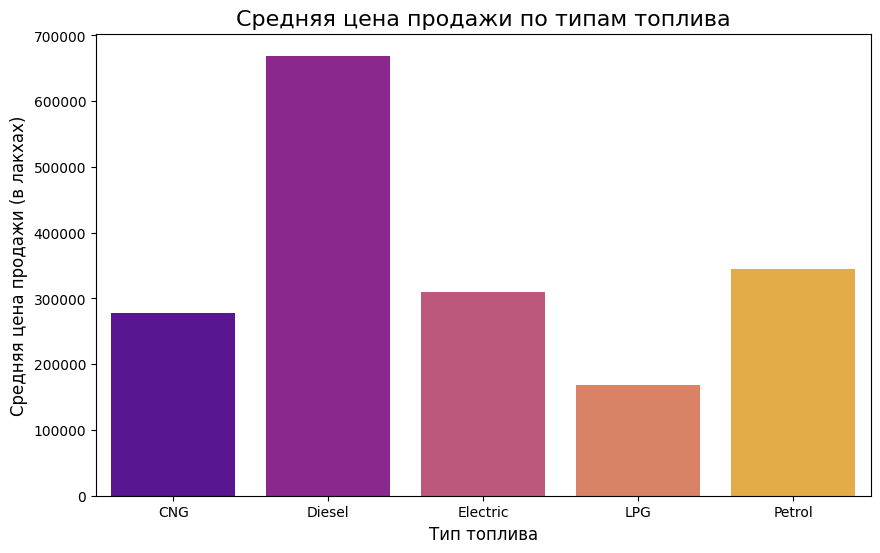

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Fuel', y='average_price', data=df_agg, palette='plasma')
plt.title('Средняя цена продажи по типам топлива', fontsize=16)
plt.xlabel('Тип топлива', fontsize=12)
plt.ylabel('Средняя цена продажи (в лакхах)', fontsize=12)
plt.show()

График 3: Зависимость цены продажи от пробега

Диаграмма рассеяния (scatter plot) — отличный способ увидеть взаимосвязь между двумя числовыми переменными.

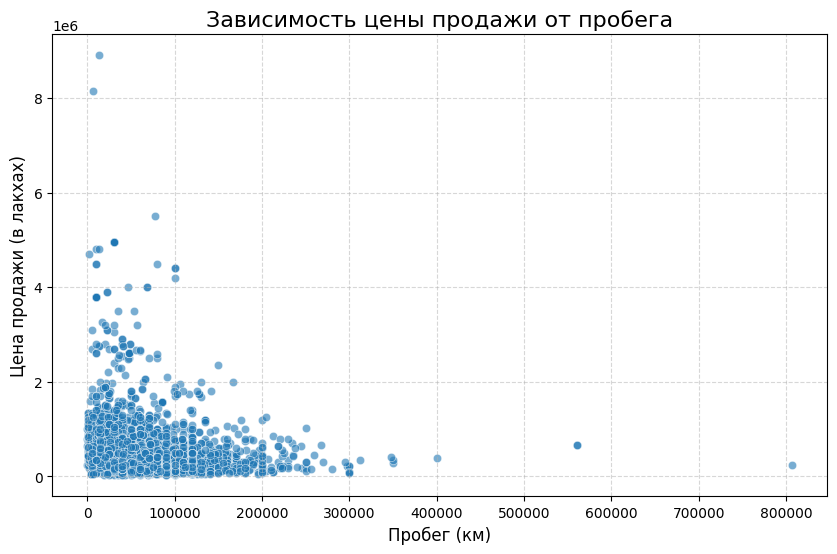

In [22]:
# Получаем данные о цене и пробеге
price_kms_query = "SELECT KM_Driven, Selling_Price FROM car_listings;"
df_price_kms = pd.read_sql_query(price_kms_query, conn)

# Строим диаграмму рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(x='KM_Driven', y='Selling_Price', data=df_price_kms, alpha=0.6)
plt.title('Зависимость цены продажи от пробега', fontsize=16)
plt.xlabel('Пробег (км)', fontsize=12)
plt.ylabel('Цена продажи (в лакхах)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()